In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import zip_longest
import os
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:
df = pd.read_csv("All measurements V2, cleaned/all_measurements_summery_30,000_cleaned.csv")

In [5]:
df

,expected_weight,run_index,force_sensor_value,force_vector_1,force_vector_2,force_vector_3,robot_tcp.velocity_linear_1,robot_tcp.velocity_linear_2,robot_tcp.velocity_linear_3,robot_tcp.velocity_angular_1,...,robot_tcp.joint_angles_4,robot_tcp.joint_angles_5,robot_tcp.joint_angles_6,robot_tcp.flange_1,robot_tcp.flange_2,robot_tcp.flange_3,robot_tcp.flange_4,robot_tcp.flange_5,robot_tcp.flange_6,robot_tcp.flange_7
0,0.335,1,0.340568,0.775,-0.453,20.0,0.079766,-0.010370,0.902352,0.000027,...,-2.721707,4.688728,-0.142706,-0.371705,-0.598554,0.068898,0.322016,0.946589,0.014908,-0.007314
1,0.335,1,0.340568,0.785,-0.431,20.0,0.079766,-0.010370,0.902352,0.000027,...,-2.721707,4.688728,-0.142706,-0.371705,-0.598554,0.068898,0.322016,0.946589,0.014908,-0.007314
2,0.335,1,0.341568,0.800,-0.402,20.0,0.153676,-0.044164,0.886970,-0.016157,...,-2.670519,4.689290,-0.137949,-0.371329,-0.598654,0.070673,0.322003,0.946594,0.014877,-0.007324
3,0.335,1,0.341568,0.810,-0.368,20.0,0.153676,-0.044164,0.886970,-0.016157,...,-2.670519,4.689290,-0.137949,-0.371329,-0.598654,0.070673,0.322003,0.946594,0.014877,-0.007324
4,0.335,1,0.342568,0.815,-0.338,19.0,0.156814,-0.048875,0.886929,-0.022112,...,-2.667505,4.689307,-0.137588,-0.371082,-0.598744,0.072457,0.322000,0.946595,0.014853,-0.007342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15179139,0.482,30973,0.567018,0.190,0.668,16126.0,0.226613,0.411088,0.686115,-0.018644,...,-1.369907,1.565777,4.407333,-0.530585,-0.187143,0.548930,-0.462112,0.886810,0.003469,-0.002924
15179140,0.482,30973,0.568018,0.230,0.691,16322.0,0.226613,0.411088,0.686115,-0.018644,...,-1.369907,1.565777,4.407333,-0.530585,-0.187143,0.548930,-0.462112,0.886810,0.003469,-0.002924
15179141,0.482,30973,0.570018,0.260,0.711,16660.0,0.226613,0.411088,0.686115,-0.018644,...,-1.369907,1.565777,4.407333,-0.530133,-0.186387,0.550307,-0.462154,0.886788,0.003433,-0.002924
15179142,0.482,30973,0.571018,0.284,0.736,16932.0,0.226613,0.411088,0.686115,-0.018644,...,-1.369907,1.565777,4.407333,-0.530133,-0.186387,0.550307,-0.462154,0.886788,0.003433,-0.002924


In [6]:
df.keys()

Index(['expected_weight', 'run_index', 'force_sensor_value', 'force_vector_1',
       'force_vector_2', 'force_vector_3', 'robot_tcp.velocity_linear_1',
       'robot_tcp.velocity_linear_2', 'robot_tcp.velocity_linear_3',
       'robot_tcp.velocity_angular_1', 'robot_tcp.velocity_angular_2',
       'robot_tcp.velocity_angular_3', 'robot_tcp.joint_angles_1',
       'robot_tcp.joint_angles_2', 'robot_tcp.joint_angles_3',
       'robot_tcp.joint_angles_4', 'robot_tcp.joint_angles_5',
       'robot_tcp.joint_angles_6', 'robot_tcp.flange_1', 'robot_tcp.flange_2',
       'robot_tcp.flange_3', 'robot_tcp.flange_4', 'robot_tcp.flange_5',
       'robot_tcp.flange_6', 'robot_tcp.flange_7'],
      dtype='object')

In [15]:
df['run_index'].value_counts().min()

401

In [16]:
for run_id, g in df.groupby('run_index'):
    label = g['expected_weight'].iloc[0]
    ts = g[ts_cols].values     # (time, num_features)

In [17]:
T = 400  # the model can only be trained of measurements on equal size. So in a measurement, all the rows after row 400 will be cut. Data analysis showed that the shortest run is 401.
def fix_len(x, T):
    n = len(x)
    if n >= T: return x[:T]
    pad = np.zeros((T - n, x.shape[1]))
    return np.vstack([x, pad])

In [18]:
X_ts, X_st, y, groups = [], [], [], []
for run_id, g in df.groupby('run_index'):
    label = g['expected_weight'].iloc[0]
    ts = g[ts_cols].values
    ts_fixed = fix_len(ts, T)
    static_vals = g[static_cols].mean().values  # mean over run
    X_ts.append(ts_fixed)
    X_st.append(static_vals)
    y.append(label)
    groups.append(run_id)

X_ts = np.array(X_ts)   # (num_runs, T, num_features)
X_st = np.array(X_st)   # (num_runs, num_static)
y = np.array(y)

In [19]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

gss = GroupShuffleSplit(test_size=0.25, random_state=42)
train_idx, test_idx = next(gss.split(X_ts, y, groups=groups))
Xts_tr, Xts_te = X_ts[train_idx], X_ts[test_idx]
Xst_tr, Xst_te = X_st[train_idx], X_st[test_idx]
y_tr,  y_te  = y[train_idx], y[test_idx]

# normalize
ts_mean = Xts_tr.mean(axis=(0,1), keepdims=True)
ts_std = Xts_tr.std(axis=(0,1), keepdims=True) + 1e-8
Xts_tr = (Xts_tr - ts_mean) / ts_std
Xts_te = (Xts_te - ts_mean) / ts_std

sc_st = StandardScaler().fit(Xst_tr)
Xst_tr = sc_st.transform(Xst_tr)
Xst_te = sc_st.transform(Xst_te)

In [20]:
from tensorflow.keras import layers, models

ts_in = layers.Input(shape=(T, Xts_tr.shape[-1]))
x = layers.Conv1D(64, 5, activation='relu', padding='same')(ts_in)
x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)

st_in = layers.Input(shape=(Xst_tr.shape[-1],))
s = layers.Dense(64, activation='relu')(st_in)

h = layers.Concatenate()([x, s])
h = layers.Dense(128, activation='relu')(h)
h = layers.Dropout(0.5)(h)
out = layers.Dense(1, activation=None)(h)  # regression (weight)

model = models.Model([ts_in, st_in], out)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 22)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 400, 64)              7104      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 400, 128)             41088     ['conv1d[0][0]']              
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]

history = model.fit(
    [Xts_tr, Xst_tr], y_tr,
    validation_split=0.2,
    epochs=50, batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
542/542 [==============================] - 21s 36ms/step - loss: 0.0437 - mae: 0.0437 - val_loss: 0.0221 - val_mae: 0.0221
Epoch 2/50
542/542 [==============================] - 19s 35ms/step - loss: 0.0291 - mae: 0.0291 - val_loss: 0.0225 - val_mae: 0.0225
Epoch 3/50
542/542 [==============================] - 18s 34ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0210 - val_mae: 0.0210
Epoch 4/50
542/542 [==============================] - 19s 35ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0203 - val_mae: 0.0203
Epoch 5/50
542/542 [==============================] - 17s 32ms/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0209 - val_mae: 0.0209
Epoch 6/50
542/542 [==============================] - 19s 36ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0207 - val_mae: 0.0207
Epoch 7/50
542/542 [==============================] - 18s 34ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 8/50
542/542 [==============================] - 19s 34ms

[0.01706956885755062, 0.01706956885755062]

In [28]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Predict using the best model
y_pred = model.predict([Xts_te, Xst_te]).flatten()

# Compute metrics
r2 = r2_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
rmse = mean_squared_error(y_te, y_pred, squared=False)

print(f"R² score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

291/291 [==============================] - 3s 9ms/step
R² score: 0.9735
MAE: 0.0171
RMSE: 0.0259


291/291 [==============================] - 2s 8ms/step


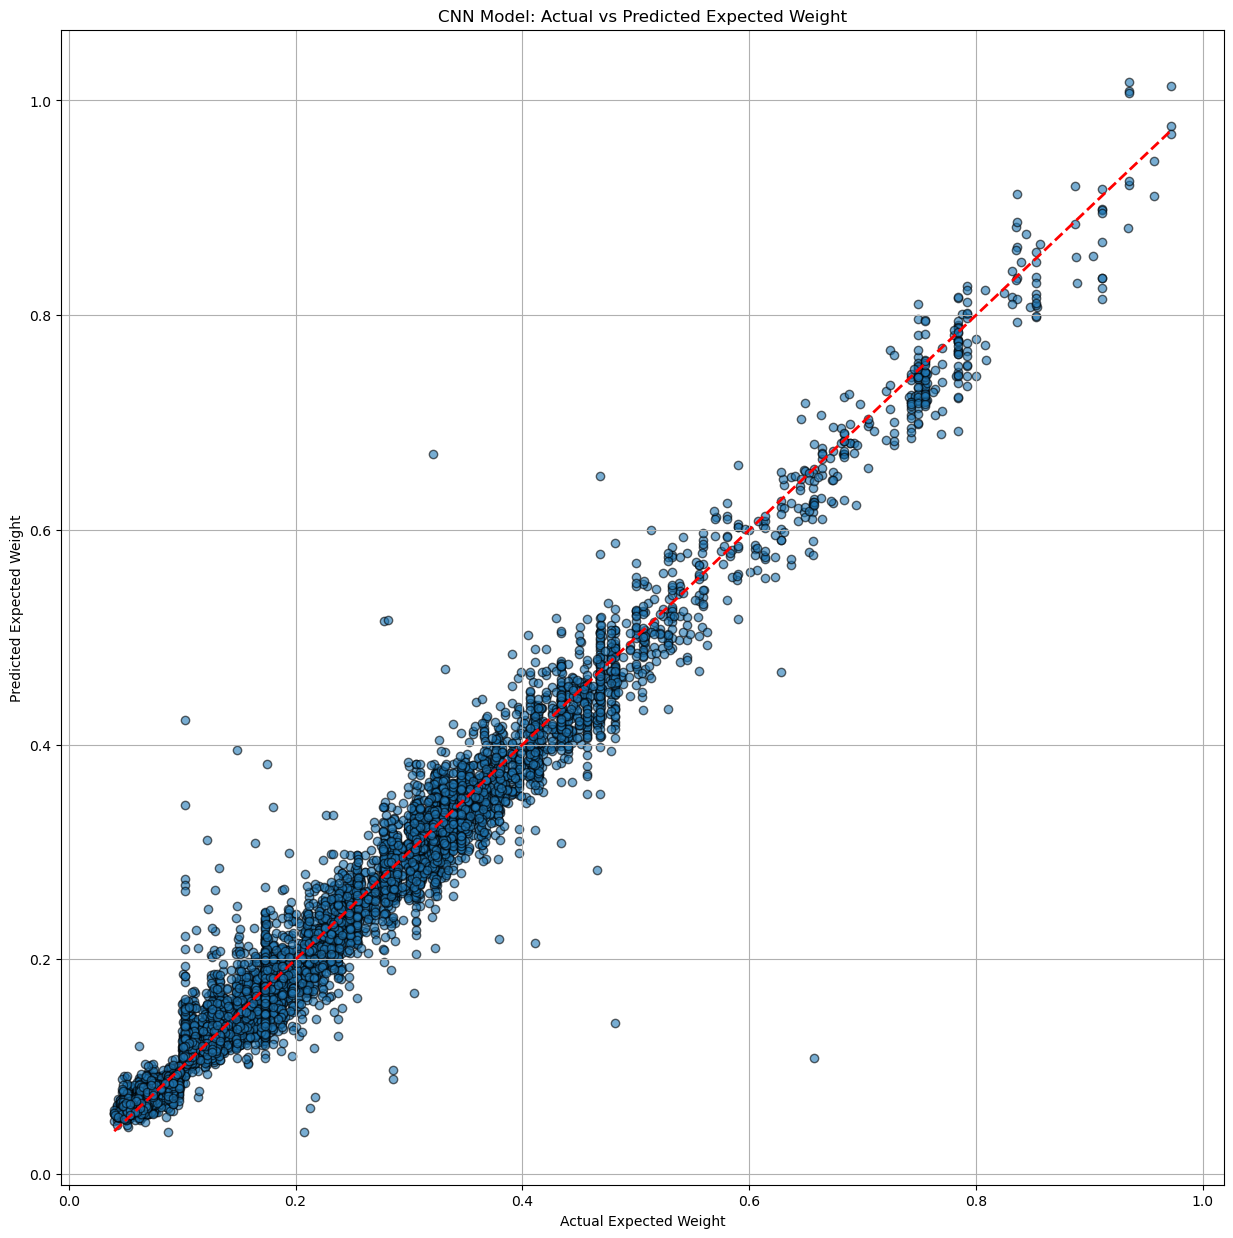

In [26]:
# Get predictions from trained model
y_pred = model.predict([Xts_te, Xst_te]).flatten()

# pick 10000 random samples, the dataset is too big.
n_samples = min(10000, len(y_te))
idx = np.random.choice(len(y_te), n_samples, replace=False)

y_true_sample = y_te[idx]
y_pred_sample = y_pred[idx]

plt.figure(figsize=(15,15))
plt.scatter(y_true_sample, y_pred_sample, alpha=0.6, edgecolor='k')
plt.plot(
    [y_true_sample.min(), y_true_sample.max()],
    [y_true_sample.min(), y_true_sample.max()],
    'r--', linewidth=2
)
plt.xlabel("Actual Expected Weight")
plt.ylabel("Predicted Expected Weight")
plt.title("CNN Model: Actual vs Predicted Expected Weight")
plt.grid(True)
plt.show()

In [29]:
# baseline performance
y_pred_base = model.predict([Xts_te, Xst_te]).flatten()
base_mae = mean_absolute_error(y_te, y_pred_base)

importances = []

for j, col in enumerate(ts_cols):  # loop over each feature
    Xts_perm = Xts_te.copy()
    np.random.shuffle(Xts_perm[:, :, j])  # shuffle that feature across samples
    y_pred_perm = model.predict([Xts_perm, Xst_te]).flatten()
    perm_mae = mean_absolute_error(y_te, y_pred_perm)
    importances.append(perm_mae - base_mae)

# rank features
feature_importance = pd.Series(importances, index=ts_cols).sort_values(ascending=False)
print(feature_importance.head(10))

291/291 [==============================] - 3s 9ms/step
robot_tcp.velocity_linear_2    0.013275
force_vector_3                 0.013158
robot_tcp.flange_3             0.011002
robot_tcp.joint_angles_5       0.004872
force_vector_1                 0.004741
force_vector_2                 0.004614
robot_tcp.joint_angles_1       0.004097
robot_tcp.velocity_linear_1    0.003467
robot_tcp.joint_angles_4       0.003291
robot_tcp.joint_angles_3       0.002317
dtype: float64
